<a href="https://colab.research.google.com/github/jqshang/CSC2541/blob/main/Experiments/grangernn_causal_discovery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jqshang/CSC2541.git
%cd CSC2541

Cloning into 'CSC2541'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (150/150), done.
remote: Total 185 (delta 68), reused 127 (delta 30), pack-reused 0 (from 0)
Receiving objects: 100% (185/185), 3.24 MiB | 32.85 MiB/s, done.
Resolving deltas: 100% (68/68), done.
/content/CSC2541


In [2]:
!pip -q install MDAnalysis MDAnalysisData

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 4.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataset.syn_data import generate_synthetic_protein_data
from model.granger_nn import GrangerNeuralNet
from model.util import adjacency_to_digraph, plot_digraph, combine_position_angle_scores, print_sccs
from model.graph import filter_paths, build_scc_quotient_graph
from train_granger_nn import train_granger_net

In [4]:
import numpy as np
import MDAnalysis as mda
from MDAnalysisData import datasets
from MDAnalysis.analysis.dihedrals import Ramachandran

adk = datasets.fetch_adk_equilibrium()
u = mda.Universe(adk.topology, adk.trajectory)
ca = u.select_atoms("protein and name CA")

T = len(u.trajectory)
N = len(ca)
pos = np.zeros((T, N, 3))

for t, ts in enumerate(u.trajectory):
    pos[t] = ca.positions.copy()

rama = Ramachandran(ca)
rama.run()
angles = rama.angles # shape: (T, 212, 2)

rama_residues = list(rama.ag3.residues)
rama_resids = np.array([res.resid for res in rama_residues])

ca_resids = np.array([res.resid for res in ca.residues])

resid_to_index = {resid: i for i, resid in enumerate(ca_resids)}
valid_residue_indices = np.array([resid_to_index[r] for r in rama_resids])

positions = pos[:, valid_residue_indices]   # (T, 212, 3)

num_residues = len(rama_residues)    # 212
amino_acids = [f"A{i+1}" for i in range(num_residues)]  # ["A1", ..., "A212"]

label_to_residue = {
    label: {
        "index": i,
        "resid": res.resid,
        "resname": res.resname
    }
    for i, (label, res) in enumerate(zip(amino_acids, rama_residues))
}

resid_to_label = {info["resid"]: label for label, info in label_to_residue.items()}


/usr/local/lib/python3.12/dist-packages/MDAnalysisData/base.py:34: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_string
adk4AKE.psf: 795kB [00:02, 395kB/s]                           
1ake_007-nowater-core-dt240ps.dcd: 168MB [00:10, 15.6MB/s]                           
/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/usr/local/lib/python3.12/dist-packages/MDAnalysis/analysis/dihedrals.py:444: UserWarning: Cannot determine phi and psi angles for the first or last residues
 

In [5]:
# pairs = [("A1", "A16"), ("A16", "A17"), ("A17", "A30"), ("A30", "A36"), ("A30", "A16"), ("A36", "A50")]
# num_acids = 50
# num_steps = 200
# positions, angles, amino_acids = generate_synthetic_protein_data(num_acids, num_steps, pairs)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/300 | MSE: 0.2271 | L1_v: 384.6772 | L1_t: 1923.3807
Epoch 100/300 | MSE: 0.0656 | L1_v: 364.4550 | L1_t: 1822.2599
Epoch 150/300 | MSE: 0.0234 | L1_v: 344.2308 | L1_t: 1721.1371
Epoch 200/300 | MSE: 0.0117 | L1_v: 324.0055 | L1_t: 1620.0135
Epoch 250/300 | MSE: 0.0080 | L1_v: 303.7799 | L1_t: 1518.8899
Epoch 300/300 | MSE: 0.0067 | L1_v: 283.5546 | L1_t: 1417.7664


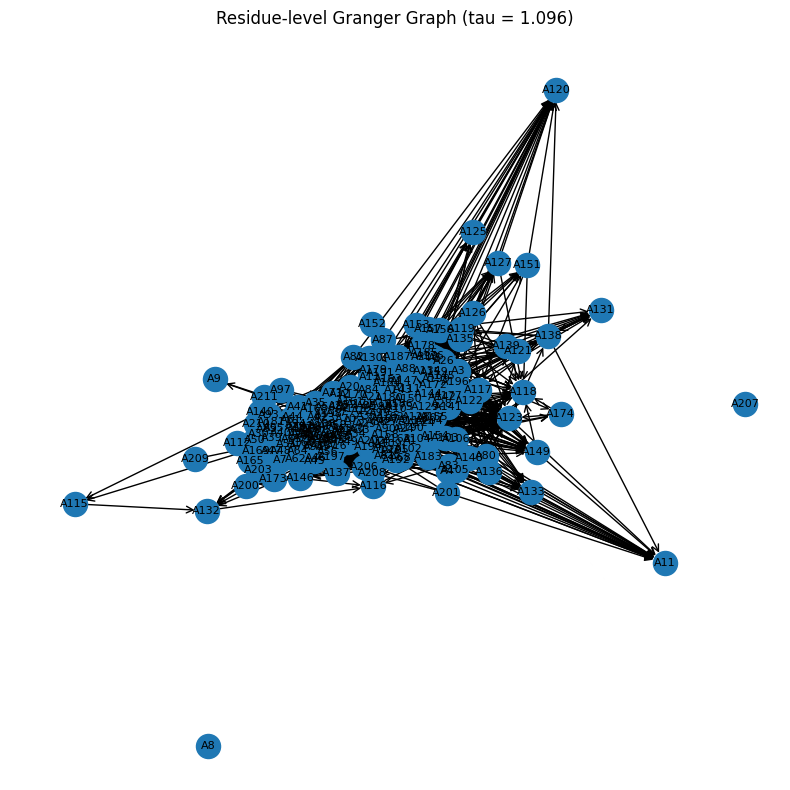

In [6]:
G_res_position, tau_position, S_res_position = train_granger_net(positions, n_epochs=300)
DG_res_position = adjacency_to_digraph(G_res_position,node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_position:.3f})"
plot_digraph(DG_res_position, node_names=amino_acids, title=plot_title)

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 50/300 | MSE: 0.0036 | L1_v: 170.9666 | L1_t: 854.8348
Epoch 100/300 | MSE: 0.0001 | L1_v: 161.9737 | L1_t: 809.8871
Epoch 150/300 | MSE: 0.0001 | L1_v: 152.9826 | L1_t: 764.9412
Epoch 200/300 | MSE: 0.0001 | L1_v: 143.9923 | L1_t: 719.9958
Epoch 250/300 | MSE: 0.0001 | L1_v: 135.0023 | L1_t: 675.0511
Epoch 300/300 | MSE: 0.0001 | L1_v: 126.0127 | L1_t: 630.1072


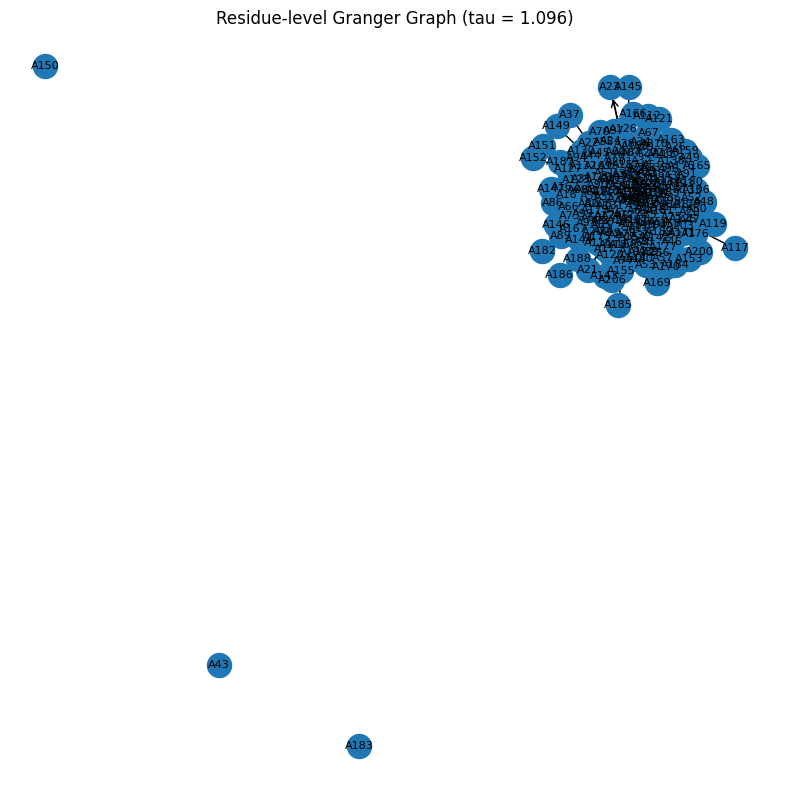

In [7]:
G_res_angle, tau_angle, S_res_angle = train_granger_net(angles, n_epochs=300)
DG_res_angle = adjacency_to_digraph(G_res_angle, node_names=amino_acids)
plot_title = f"Residue-level Granger Graph (tau = {tau_angle:.3f})"
plot_digraph(DG_res_angle, node_names=amino_acids, title=plot_title)

Combined threshold (tau_comb): 0.999853
Number of residue edges in combined graph: 2247


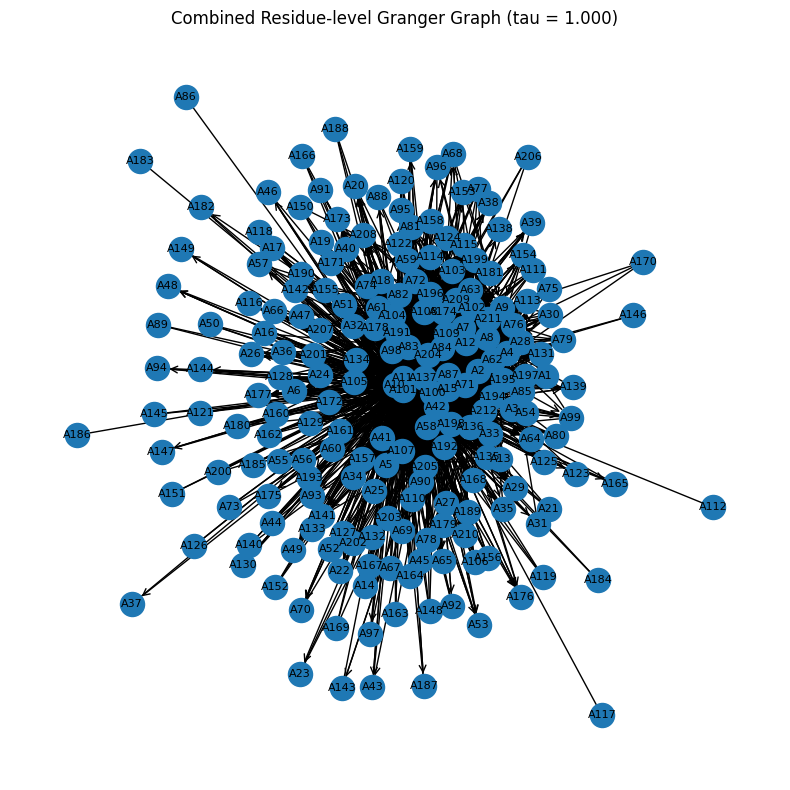

In [8]:
G_res_comb, tau_comb, S_res_comb = combine_position_angle_scores(S_res_position, S_res_angle)
print("Combined threshold (tau_comb):", tau_comb)
print("Number of residue edges in combined graph:", G_res_comb.sum())

DG_res_comb = adjacency_to_digraph(G_res_comb, node_names=amino_acids)
plot_title = f"Combined Residue-level Granger Graph (tau = {tau_comb:.3f})"
plot_digraph(DG_res_comb, node_names=amino_acids, title=plot_title)

In [16]:
import networkx as nx
from collections import deque

def _reachable_from_sources(DG, sources):
    """Multi-source BFS/DFS to get all nodes reachable from any of `sources`."""
    visited = set(sources)
    dq = deque(sources)

    while dq:
        u = dq.popleft()
        for v in DG.successors(u):
            if v not in visited:
                visited.add(v)
                dq.append(v)

    return visited


def filter_paths(DG, amino_acids, allosteric_sites, active_sites):
    """
    DG: DiGraph whose nodes are indices 0..N-1 (matching amino_acids list)
    amino_acids: list of residue names, e.g. ["A1", "A2", ...]
    allosteric_sites: list of residue names, e.g. ["A1", "A2"]
    active_sites: list of residue names, e.g. ["A38", "A50"]

    Returns:
        signaling_subgraph: DiGraph with only edges that lie on some
                            path from an allosteric site to an active site.
        used_nodes: set of node indices in that subgraph
        used_edges: set of (u, v) edges in that subgraph
    """
    # Map residue name -> index
    name_to_idx = {name: i for i, name in enumerate(amino_acids)}

    allo_idx = [name_to_idx[name] for name in allosteric_sites]
    active_idx = [name_to_idx[name] for name in active_sites]

    # 1) Forward reachability from allosteric sites
    forward = _reachable_from_sources(DG, allo_idx)

    # 2) Backward reachability to active sites (via reversed graph)
    DG_rev = DG.reverse(copy=False)
    backward = _reachable_from_sources(DG_rev, active_idx)

    # 3) Keep edges that can sit on some allo -> active path
    used_edges = set()
    for u, v in DG.edges():
        if (u in forward) and (v in backward):
            used_edges.add((u, v))

    signaling_subgraph = DG.edge_subgraph(used_edges).copy()
    used_nodes = set(signaling_subgraph.nodes())

    return signaling_subgraph, used_nodes, used_edges


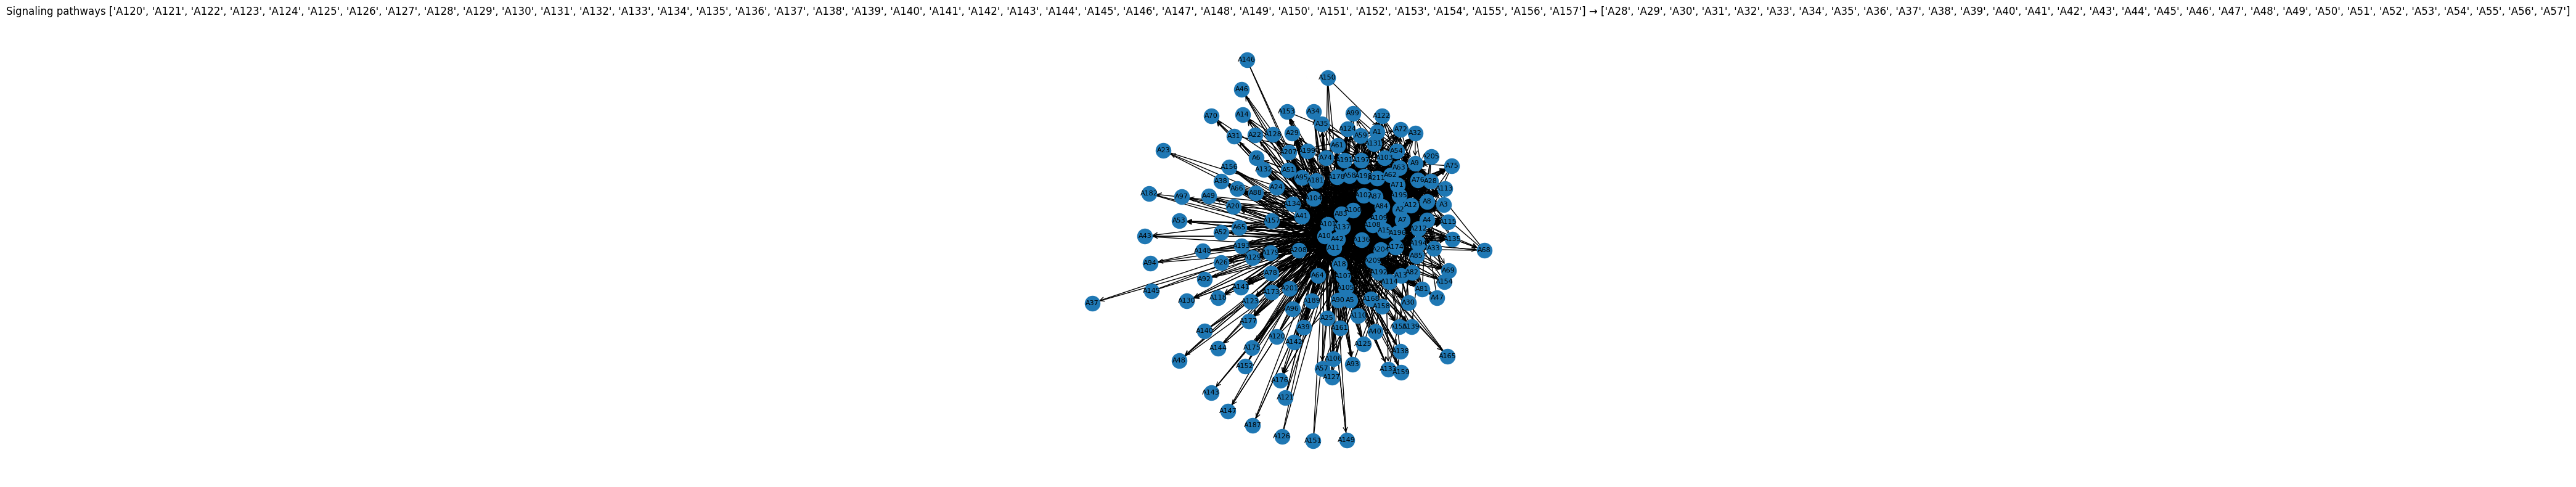

In [20]:
# assuming plot_digraph(DG, node_names, title) is already defined

allosteric_sites = [f"A{i}" for i in range(120, 158)]
active_sites = [f"A{i}" for i in range(28, 58)]

DG_signal, used_nodes, used_edges = filter_paths(
    DG_res_comb,
    amino_acids,
    allosteric_sites,
    active_sites,
)

plot_title = f"Signaling pathways {allosteric_sites} → {active_sites}"
plot_digraph(DG_signal, node_names=amino_acids, title=plot_title)

Strongly connected components (SCCs):
  SCC 0: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, A15, A18, A20, A22, A23, A24, A25, A26, A28, A29, A30, A31, A32, A33, A34, A35, A37, A38, A39, A40, A41, A42, A43, A46, A47, A48, A49, A51, A52, A53, A54, A57, A58, A59, A61, A62, A63, A64, A65, A66, A68, A69, A70, A71, A72, A74, A75, A76, A78, A81, A82, A83, A84, A85, A87, A88, A90, A92, A93, A94, A95, A96, A97, A99, A100, A101, A102, A103, A104, A105, A106, A107, A108, A109, A110, A113, A114, A115, A118, A122, A123, A124, A125, A128, A129, A130, A131, A133, A134, A135, A136, A137, A138, A139, A141, A142, A143, A144, A147, A149, A153, A154, A155, A157, A158, A159, A161, A165, A168, A173, A174, A175, A176, A177, A178, A179, A181, A182, A187, A189, A191, A192, A193, A194, A195, A196, A197, A198, A199, A201, A204, A205, A207, A208, A209, A211, A212
  SCC 1: A120
  SCC 2: A121
  SCC 3: A126
  SCC 4: A127
  SCC 5: A132
  SCC 6: A140
  SCC 7: A145
  SCC 8: A146
  SCC 9: A148
  SCC 10:

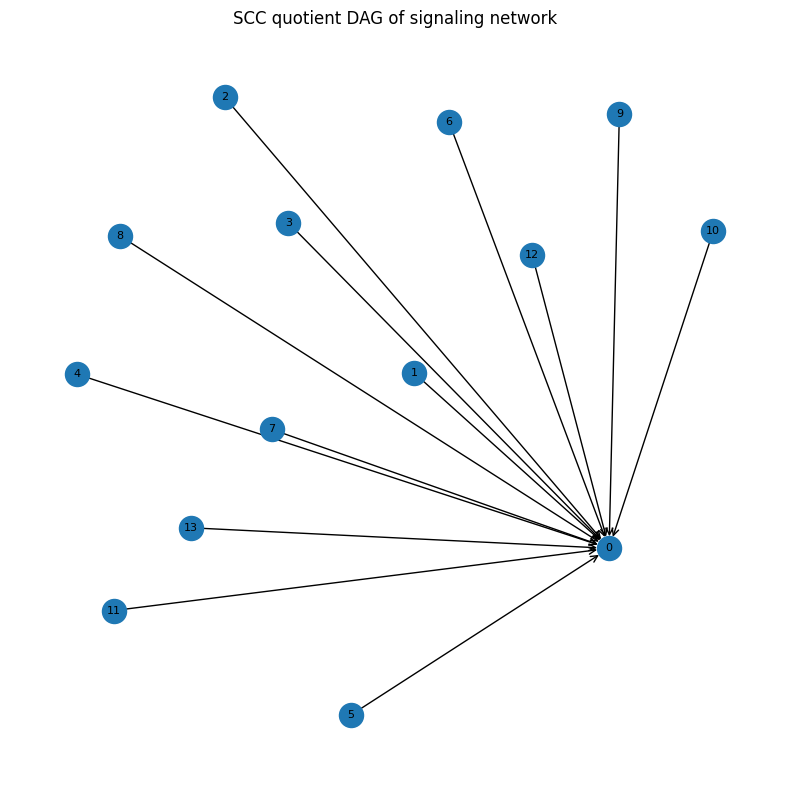

In [21]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)

In [ ]:
sccs, node_to_scc, Q = build_scc_quotient_graph(DG_signal, amino_acids)

print_sccs(sccs, amino_acids)

plot_title = "SCC quotient DAG of signaling network"
plot_digraph(Q, title=plot_title)